In [1]:
import matplotlib.pyplot as plt
import torch
from openforcefield.topology import Molecule
from tqdm import tqdm

from espaloma.redux.energy import compute_valence_energy
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements


def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, 2), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    valence_model = ValenceModel(node_representation, readouts)
    return valence_model

Using backend: pytorch


In [2]:
valence_model = initialize()

#### Load dataset

In [3]:
path_to_dataset = '../../data/qca/*.h5'

In [4]:
from glob import glob

In [5]:
paths_to_datsets = glob(path_to_dataset)
paths_to_datsets

['../../data/qca/eMolecules.h5',
 '../../data/qca/Roche.h5',
 '../../data/qca/Coverage.h5',
 '../../data/qca/Bayer.h5',
 '../../data/qca/Pfizer.h5']

In [6]:
import pandas as pd

In [7]:
df = pd.read_hdf('../../data/qca/Roche.h5')
df

,offmol,xyz,energies,gradients
c1ccc(c(c1)c2c=cnc=c2)[n+](=o)[o-]-0,Molecule with name '' and SMILES '[H]c1c(c(c(c...,"[[[8.64368188, -0.36839034, -1.642932], [8.542...","[-685.1245763393297, -685.125632691076, -685.1...","[[[-0.0005868442762516273, -0.0009118189676851..."
c1ccc(c(c1)c2c=cnc=c2)[n+](=o)[o-]-1,Molecule with name '' and SMILES '[H]c1c(c(c(c...,"[[[8.64368188, -0.36839034, -1.642932], [8.542...","[-685.1168302849942, -685.1251284611758, -685....","[[[-0.0029031063779140056, 0.00088637924910335..."
c1cnc(nc1)c2ncco2-0,Molecule with name '' and SMILES '[H]c1c(nc(nc...,"[[[1.11135101, 1.68283819, 3.52634778], [0.427...","[-509.2855426266222, -509.28644214015253, -509...","[[[-0.0038854577356293094, -0.0023258691569085..."
cn1ccnc1c2ccccc2-0,Molecule with name '' and SMILES '[H]c1c(c(c(c...,"[[[3.56240001, -1.95833547, -0.21248155], [5.5...","[-496.6661997769336, -496.6661031011264, -496....","[[[-0.0003726804546595755, 3.1808791622076245e..."
cn(c)s(=o)(=o)c1ncco1-0,Molecule with name '' and SMILES '[H]C1=C(OC(=...,"[[[-1.98090286, 6.84208296, 4.10496305], [-3.9...","[-928.6754897145471, -928.6807107448581, -928....","[[[0.014644098237170432, -0.007984321246469181..."
...,...,...,...,...
c1ccc(c(c1)c#n)nc(=o)nc2ccccn2-0,Molecule with name '' and SMILES '[H]c1c(c(c(c...,"[[[7.97378783, -1.16651899, 5.16631293], [3.55...","[-795.7726140630207, -795.7757536445863, -795....","[[[0.012503369954526649, 0.002427863961968043,..."
c1ccc(c(c1)c#n)nc(=o)nc2ccccn2-1,Molecule with name '' and SMILES '[H]c1c(c(c(c...,"[[[7.97378783, -1.16651899, 5.16631293], [3.55...","[-795.7823425237151, -795.7863967313793, -795....","[[[0.011935341650909703, 0.0023166709410819904..."
c1ccc(c(c1)c#n)nc(=o)nc2ccccn2-2,Molecule with name '' and SMILES '[H]c1c(c(c(c...,"[[[0.36880397, 1.48286377, 4.78434695], [3.751...","[-795.7605490505065, -795.764679823452, -795.7...","[[[-0.004108383263444142, 0.005581976997648781..."
c1ccc(c(c1)c#n)nc(=o)nc2ccccn2-3,Molecule with name '' and SMILES '[H]c1c(c(c(c...,"[[[1.88089532, -6.43620425, 4.83770013], [3.71...","[-795.76054659861, -795.7646771685934, -795.76...","[[[-0.0017513500670877718, -0.0067168657881853..."


In [8]:
unique_mols = list(set(df.offmol))
len(unique_mols)

100

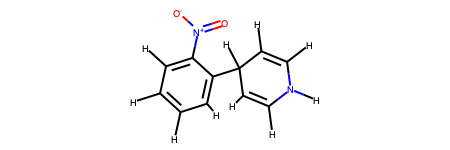

In [9]:
offmol = df.offmol[df.index[0]]
offmol

In [10]:
%%time
valence_model.forward(offmol)

CPU times: user 144 ms, sys: 10.7 ms, total: 155 ms
Wall time: 138 ms


ParameterizedSystem(atoms=tensor([[0.0263, 0.0697],
        [0.0267, 0.0697],
        [0.0255, 0.0729],
        [0.0341, 0.0747],
        [0.0323, 0.0707],
        [0.0236, 0.0630],
        [0.0281, 0.0727],
        [0.0281, 0.0727],
        [0.0301, 0.0688],
        [0.0301, 0.0688],
        [0.0267, 0.0681],
        [0.0384, 0.0752],
        [0.0894, 0.0874],
        [0.0368, 0.0735],
        [0.0368, 0.0735],
        [0.0304, 0.0698],
        [0.0302, 0.0703],
        [0.0317, 0.0702],
        [0.0329, 0.0718],
        [0.0312, 0.0707],
        [0.0312, 0.0707],
        [0.0322, 0.0772],
        [0.0322, 0.0772],
        [0.0301, 0.0711],
        [0.0386, 0.0713]], grad_fn=<AddmmBackward>), bonds=tensor([[ 0.3629, -0.2325],
        [ 0.3655, -0.2355],
        [ 0.3473, -0.2436],
        [ 0.3632, -0.2333],
        [ 0.3466, -0.2434],
        [ 0.3638, -0.2352],
        [ 0.3466, -0.2429],
        [ 0.3583, -0.2343],
        [ 0.3456, -0.2444],
        [ 0.3558, -0.2334],
        [ 0

In [11]:
%%time

for offmol in unique_mols:
    params = valence_model.forward(offmol)

CPU times: user 4.36 s, sys: 98.4 ms, total: 4.46 s
Wall time: 1.13 s


In [12]:
import numpy as np
xyz = np.vstack(df.xyz[df.offmol == offmol])
xyz.shape

(121, 24, 3)

In [13]:
xyzs = dict()
energies = dict()

for offmol in unique_mols:
    mask = df.offmol == offmol
    xyzs[offmol] = torch.tensor(np.vstack(df.xyz[mask]))
    energies[offmol] = torch.tensor(np.hstack(df.energies[mask]))
    
    # check same number of total snapshots
    assert(xyzs[offmol].shape[0] == energies[offmol].shape[0])

#### Double-check, is there much overhead for using this dictionary approach?

In [14]:
%%time
for offmol in unique_mols:
    _ = xyzs[offmol]

CPU times: user 390 µs, sys: 0 ns, total: 390 µs
Wall time: 395 µs


I mean, a lot compared with if I were doing things efficiently, but not a lot in the grand scheme of the computation being performed here...

In [15]:
def residual_stddev(x, y):
    return torch.std(x - y)

def loss_on_one_mol(offmol):
    # make predictions
    params = valence_model.forward(offmol)
    pred_energies = compute_valence_energy(offmol, xyzs[offmol], params)
    
    # get reference
    ref_energies = energies[offmol]
    
    # compute residual stddev, aka rmse up to an arbitrary constant
    return residual_stddev(pred_energies, ref_energies)

In [16]:
%%time
loss_on_one_mol(offmol)

CPU times: user 90.5 ms, sys: 12.6 ms, total: 103 ms
Wall time: 58.8 ms


tensor(0.6314, dtype=torch.float64, grad_fn=<StdBackward0>)

In [17]:
%%time

for offmol in unique_mols:
    l = loss_on_one_mol(offmol)

CPU times: user 9.14 s, sys: 388 ms, total: 9.52 s
Wall time: 2.41 s


In [18]:
def loss():
    """mean over all molecules"""
    L = 0.0
    for offmol in unique_mols:
        L += loss_on_one_mol(offmol)
    return L / len(unique_mols)

In [19]:
%%time

loss()

CPU times: user 9.32 s, sys: 515 ms, total: 9.84 s
Wall time: 2.63 s


tensor(1.5388, dtype=torch.float64, grad_fn=<DivBackward0>)

In [20]:
from qcelemental import constants
from simtk import unit

report_unit = unit.kilocalorie_per_mole

def to_kcalmol(e_hartree):
    return e_hartree * constants.hartree2kcalmol


In [22]:
to_kcalmol(1.5)

941.2642106663061

In [23]:
# optimize using L-BFGS
lbfgs_options = dict(line_search_fn='strong_wolfe', history_size=10, max_iter=1)
# max_iter is # of L-BFGS iterations per torch.optim "step"

optimizer = torch.optim.LBFGS(valence_model.parameters(), **lbfgs_options)

def closure():
    optimizer.zero_grad()
    L = loss()
    L.backward(retain_graph=True)
    return L

loss_traj = [loss().detach().numpy()]
valence_model.train()

trange = tqdm(range(100))
for epoch in trange:
    L = optimizer.step(closure).detach().numpy()

    loss_traj.append(float(L))
    trange.set_postfix(loss=to_kcalmol(L))

100%|██████████| 100/100 [12:13<00:00,  7.34s/it, loss=25.1]


Text(0, 0.5, 'loss (residual stddev, in kilocalorie/mole)')

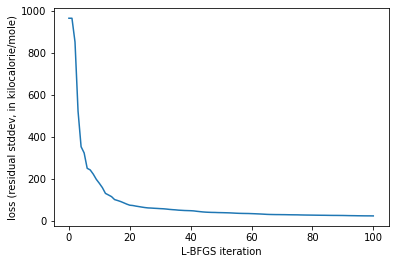

In [25]:
plt.plot([to_kcalmol(l) for l in loss_traj])
plt.xlabel('L-BFGS iteration')
plt.ylabel(f'loss (residual stddev, in {report_unit})')

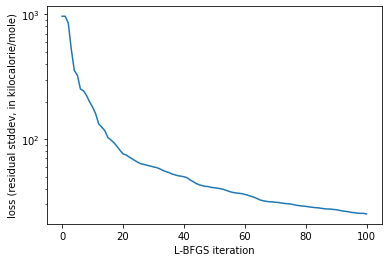

In [26]:
plt.plot([to_kcalmol(l) for l in loss_traj])
plt.xlabel('L-BFGS iteration')
plt.ylabel(f'loss (residual stddev, in {report_unit})')
plt.yscale('log')

#### What if we do this with Adam and minibatches...

In [27]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(valence_model.parameters(), lr=learning_rate)

CPU times: user 292 µs, sys: 31 µs, total: 323 µs
Wall time: 327 µs


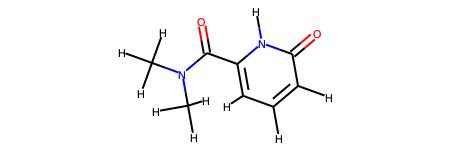

In [28]:
%%time
np.random.choice(unique_mols)

In [29]:
def compute_loss_on_one_mol(offmol, xyz, ref_energies):
    # make predictions
    params = valence_model.forward(offmol)
    pred_energies = compute_valence_energy(offmol, xyz, params)
    
    return residual_stddev(pred_energies, ref_energies)

In [30]:
def compute_loss_on_random_sample(n_mols=10, n_snapshots_per_mol=100):
    mols = np.random.choice(unique_mols, n_mols)
    L = 0
    for mol in mols:
        inds = np.random.choice(np.arange(len(xyzs[mol])), n_snapshots_per_mol)
        L += compute_loss_on_one_mol(mol, xyzs[mol][inds], energies[mol][inds])
    return L / n_mols

In [31]:
%%time
compute_loss_on_random_sample(n_mols=1)

CPU times: user 191 ms, sys: 11 ms, total: 202 ms
Wall time: 53.3 ms


tensor(0.0350, dtype=torch.float64, grad_fn=<DivBackward0>)

In [32]:
%%time
compute_loss_on_random_sample(n_mols=10)

CPU times: user 1.25 s, sys: 55 ms, total: 1.3 s
Wall time: 329 ms


tensor(0.0386, dtype=torch.float64, grad_fn=<DivBackward0>)

In [33]:
batch_losses = []
trange = tqdm(range(1000))
for t in trange:
    L = compute_loss_on_random_sample(n_mols=10)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    trange.set_postfix(batch_loss=to_kcalmol(batch_losses[-1]))

100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s, batch_loss=13.4]


In [36]:
# what residual stddev should we expect if our model just predicted a constant
constant_prediction_baseline = np.mean([to_kcalmol(torch.std(e)) for e in energies.values()])
constant_prediction_baseline

1.7586328929533324

Text(0, 0.5, 'batch loss\n(kilocalorie/mole)')

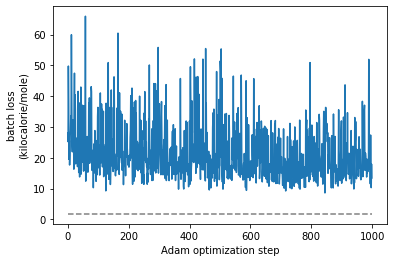

In [37]:
plt.plot([to_kcalmol(l) for l in batch_losses])
plt.hlines(constant_prediction_baseline, 0, len(batch_losses), color='grey', linestyle='--')
plt.xlabel('Adam optimization step')
plt.ylabel(f'batch loss\n({report_unit})')

#### Okay, so this is currently doing much worse than predicting a constant!

#### TODO: review and modify optimization strategy
* unit conversions and scalings
* add gradients again
* double-check float32 vs. float64
* initialization / pre-training
* predicting an offset to reasonable parameters, rather than predicting parameters from scratch
* double-check improper indices

In [38]:
params = valence_model.forward(offmol)

In [39]:
params.bonds

tensor([[0.3437, 0.5226],
        [0.3431, 0.5096],
        [0.3556, 0.3693],
        [0.3413, 0.5092],
        [0.3546, 0.3685],
        [0.3314, 0.5028],
        [0.3526, 0.3530],
        [0.3436, 0.4834],
        [0.3530, 0.3495],
        [0.3332, 0.4937],
        [0.3286, 0.4335],
        [0.3581, 0.5358],
        [0.4122, 0.5666],
        [0.4200, 0.4292],
        [0.4200, 0.4292],
        [0.4200, 0.4292],
        [0.4122, 0.5666],
        [0.4200, 0.4292],
        [0.4200, 0.4292],
        [0.4200, 0.4292],
        [0.3955, 0.5609],
        [0.3866, 0.3995],
        [0.3866, 0.3995],
        [0.3366, 0.3048]], grad_fn=<AddBackward0>)

Text(0.5, 1.0, 'bond params')

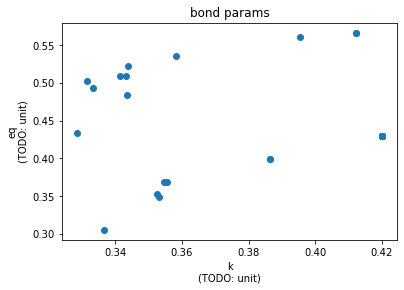

In [48]:
k, eq = params.bonds.detach().numpy().T
plt.scatter(k, eq)
plt.xlabel('k\n(TODO: unit)')
plt.ylabel('eq\n(TODO: unit)')
plt.title('bond params')

Text(0.5, 1.0, 'angle params')

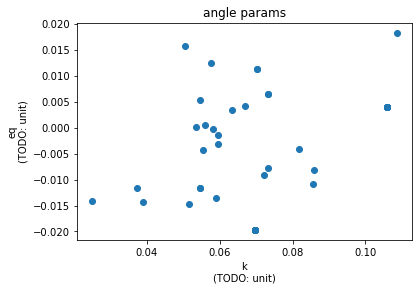

In [50]:
k, eq = params.angles.detach().numpy().T
plt.scatter(k, eq)
plt.xlabel('k\n(TODO: unit)')
plt.ylabel('eq\n(TODO: unit)')
plt.title('angle params')

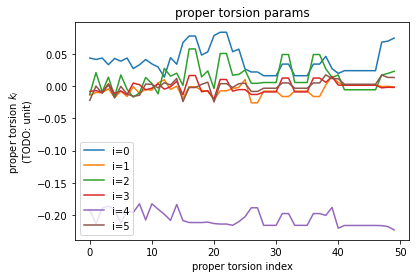

In [51]:
for i, k_i in enumerate(params.propers.detach().numpy().T):
    plt.plot(k_i, label=f"i={i}")
plt.xlabel('proper torsion index')
plt.title('proper torsion params')
plt.ylabel('proper torsion $k_i$\n(TODO: unit)')
plt.legend()

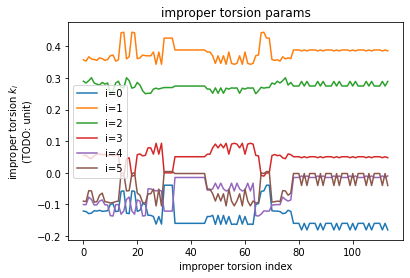

In [52]:
for i, k_i in enumerate(params.impropers.detach().numpy().T):
    plt.plot(k_i, label=f"i={i}")
plt.xlabel('improper torsion index')
plt.title('improper torsion params')
plt.ylabel('improper torsion $k_i$\n(TODO: unit)')
plt.legend()